<a href="https://colab.research.google.com/github/2022Group3/projectNotebooks/blob/main/experiments/analize_model_not_confident_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import load_model
import numpy as np
import sys
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model=load_model(r'drive/MyDrive/new_model.h5')
# csv_data= pd.read_csv(r'drive/MyDrive/data.csv')

In [ ]:
def load_dataset():
  data=np.load(r'drive/MyDrive/data_modified_new_labels.npz')
  data=dict(zip(("{}".format(k) for k in data),(data[k] for k in data)))
  trainX=data['train']
  trainy=data['ytrain']
  validationX=data['validation']
  validationy=data['yvalidation']
  testX=data['test']
  testy=data['ytest']
  return trainX,to_categorical(trainy),validationX,to_categorical(validationy),testX,to_categorical(testy)

In [ ]:
# scale pixels
def prep_pixels(testX):
  # convert from integers to floats
  testX_norm = testX.astype('float32')
  # normalize to range 0-1
  testX_norm = testX_norm / 255.0
  
  # return normalized images
  return testX_norm

In [ ]:
trainX,trainy,validationX,validationy,testX,testy=load_dataset()

In [ ]:
testy.shape

(22500, 15)

In [ ]:

testX=prep_pixels(testX)

In [ ]:
# 1
# Dif between 2 first. Green if first predict is true, Else red.
def img_pred_and_sum_of_d(pred1, pred2, real):
  if pred1[0] == real:
    good_pred = True
  else:
    good_pred = False
  dif= pred1[1]- pred2[1]
  return good_pred, dif


def plot_graph(testy, pred):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= [np.argmax(pred[i]), np.max(pred[i])*100]
    pred[i, np.argmax(pred[i])]=0.0
    pred2= [np.argmax(pred[i]), np.max(pred[i])*100]
    good_pred,dif = img_pred_and_sum_of_d(pred1, pred2, np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()

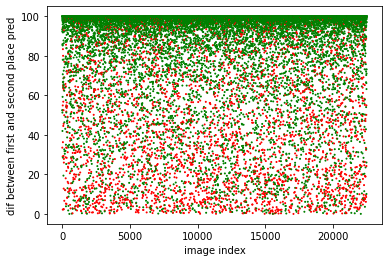

In [ ]:
plot_graph(testy, model.predict(testX))

In [ ]:
# 2
# Dif between 2 first. Green if true in first predict or second. Else red 
def img_pred_and_sum_of_d2(pred1, pred2, real):
  if pred1[0] == real or pred2[0] == real:
    good_pred = True
  else:
    good_pred = False
  dif= pred1[1]- pred2[1]
  return good_pred, dif

def plot_graph2(testy, pred):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= [np.argmax(pred[i]), np.max(pred[i])*100]
    pred[i, np.argmax(pred[i])]=0.0
    pred2= [np.argmax(pred[i]), np.max(pred[i])*100]
    good_pred,dif = img_pred_and_sum_of_d2(pred1, pred2, np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()

 

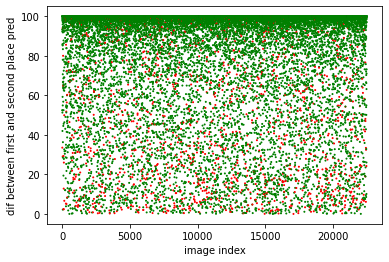

In [ ]:
plot_graph2(testy, model.predict(testX))

In [ ]:
# 3
# Sum of dif between sorted predicts array. Green if first predict is true

def img_pred_and_sum_of_d_all(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(len(sorted_preds)-1):
    sumdif+= sorted_preds[i]-sorted_preds[i+1]
  
  return good_pred, sumdif

def plot_graph_all(testy, preds):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif = img_pred_and_sum_of_d_all(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()



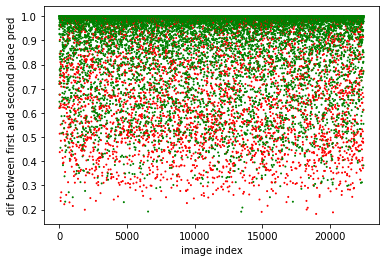

In [ ]:
plot_graph_all(testy, model.predict(testX))




In [ ]:
# 4
# Sum of probs dif and sum of 2 highest proba
def img_pred_and_sum_of_d_all2(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(len(sorted_preds)-1):
    sumdif+= sorted_preds[i]-sorted_preds[i+1]
  sum_two_first= sorted_preds[0]+sorted_preds[1]
  
  return good_pred, sumdif, sum_two_first

def plot_graph_all_sum(testy, preds):
  good_pred_list= []
  dif_list= []
  sum_two_first_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif, sum_two_first = img_pred_and_sum_of_d_all2(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
    sum_two_first_list.append(sum_two_first)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(sum_two_first_list, dif_list, c=mycolors, s=1)
  plt.xlabel('Sum of first and second prob')
  plt.ylabel('Sum all probabilty diff')
  plt.show()

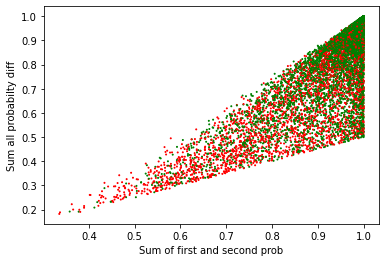

In [ ]:
plot_graph_all_sum(testy, model.predict(testX))


In [ ]:
# 5
# sum of proba with weights by first place, swcond place and so on...
def img_sum_pred_weight(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False

  sorted_preds= np.sort(preds)[::-1]
  sum_weight=0
  num_proba= len(preds)
  for i in range(len(sorted_preds)-1):
    if num_proba-i < (num_proba/3):
      w=0.5
    elif num_proba-i < (num_proba/3)*2:
      w=1.0
    else:
        w=2.0
    sum_weight+= (sorted_preds[i])*(num_proba-i)*(num_proba-i)*w
  
  return good_pred, sum_weight

def plot_graph_all_sum3(testy, preds):
  good_pred_list= []
  sum_weight_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,sum_weight = img_sum_pred_weight(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    sum_weight_list.append(sum_weight)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)),sum_weight_list , c=mycolors, s=1)
  plt.xlabel('Image index')
  plt.ylabel('Sum all probabilty with weights')
  plt.show()

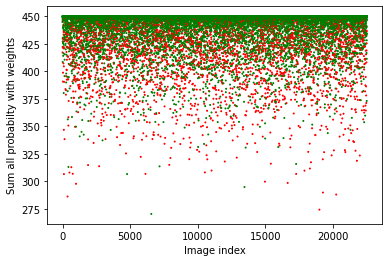

In [ ]:
plot_graph_all_sum3(testy, model.predict(testX))


הגרף הבא הוספתי מאוחר יותר:
מחשב את סכום המרחק של כל ההסתברות מההסתברות הראשונה

In [ ]:
# 6
# Sum of dif from first between sorted predicts array. Green if first predict is true

def img_pred_and_sum_of_d_all_first(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(1, len(sorted_preds)):
    sumdif+= sorted_preds[0]-sorted_preds[i]
  
  return good_pred, sumdif

def plot_graph_all_first(testy, preds):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif = img_pred_and_sum_of_d_all_first(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()


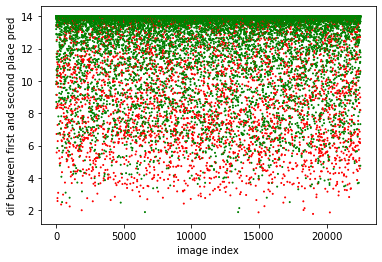

In [ ]:
plot_graph_all_first(testy, model.predict(testX))


גרף מעניין נוסף: סכום ההפרש הראשון פחות שאר ההפרשים

In [ ]:

def img_pred_and_sum_of_d_first_not_all(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(1, len(sorted_preds)-1):
    sumdif+= sorted_preds[i]-sorted_preds[i+1]
  first_diff=sorted_preds[0]-sorted_preds[1]
  
  return good_pred, first_diff-sumdif

def plot_graph_first_not_all(testy, preds):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif = img_pred_and_sum_of_d_first_not_all(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()


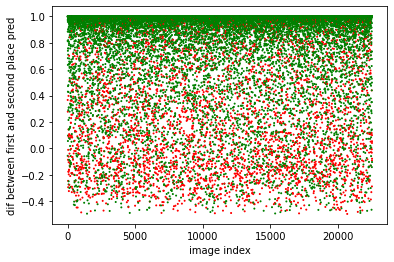

In [ ]:
plot_graph_first_not_all(testy, model.predict(testX))


השאר סתם כל מיני משחקים, די חוזר על עצמו

In [ ]:

def img_pred_and_sum_of_d_first_not_all1(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(1, len(sorted_preds)-1):
    sumdif+= sorted_preds[i]-sorted_preds[i+1]
  first_diff=sorted_preds[0]-sorted_preds[1]
  
  return good_pred, first_diff-sumdif

def plot_graph_first_not_all1(testy, preds):
  good_pred_list= []
  dif_list= []
  first_sum=[]
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif = img_pred_and_sum_of_d_first_not_all1(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
    first_sum.append(np.max(preds[i]))
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(first_sum, dif_list, c=mycolors, s=1)
  plt.xlabel('first proba')
  plt.ylabel('dif between first and second place pred')
  plt.show()

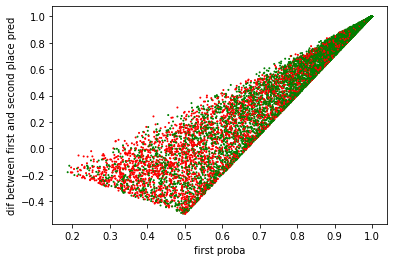

In [ ]:
plot_graph_first_not_all1(testy, model.predict(testX))


In [ ]:
def img_pred_and_sum_of_d_first_not_all2(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(1, len(sorted_preds)-1):
    sumdif+= sorted_preds[i]-sorted_preds[i+1]
  first_diff=sorted_preds[0]-sorted_preds[1]
  
  return good_pred, first_diff-sumdif

def plot_graph_first_not_all2(testy, preds):
  good_pred_list= []
  dif_list= []
  first_second_sum=[]
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif = img_pred_and_sum_of_d_first_not_all2(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
    first_second_sum.append(np.max(preds[i])+ sorted(preds[i])[-2])
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(first_second_sum, dif_list, c=mycolors, s=1)
  plt.xlabel('sum of first and second proba')
  plt.ylabel('dif between first all')
  plt.show()

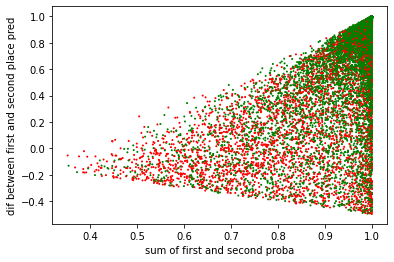

In [ ]:
plot_graph_first_not_all2(testy, model.predict(testX))


סכום גובה 2 ההסתברויות הראשונות

In [ ]:
def img_pred(pred1, pred2,pred_label, real):

  if pred_label == real:
    good_pred = True
  else:
    good_pred = False
  
  return good_pred, pred1+pred2

def plot_(testy, preds):
  good_pred_list= []
  sum_list= []
  for i in range(len(testy)):
    pred1= sorted(preds[i])[-1]
    pred2= sorted(preds[i])[-2]
    good_pred,sum = img_pred(pred1, pred2, np.argmax(preds[i]), np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    sum_list.append(sum)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), sum_list, c=mycolors, s=1)
  plt.xlabel('Image')
  plt.ylabel('Sum first 2')
  plt.show()

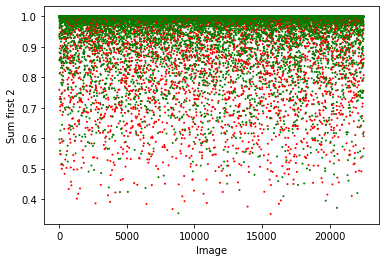

In [ ]:
plot_(testy, model.predict(testX))


חישוב של גובה ההסתברות הראשונה פחות סכום שאר ההסתברויות

In [ ]:
def img_pred_first_not_all(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  my_sum= sorted_preds[0]- sum(sorted_preds[1:])
  first_diff=sorted_preds[0]-sorted_preds[1]
  return good_pred, my_sum

def plot_graph_first_not_all22(testy, preds):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif = img_pred_first_not_all(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('first proba substract other proba')
  plt.show()

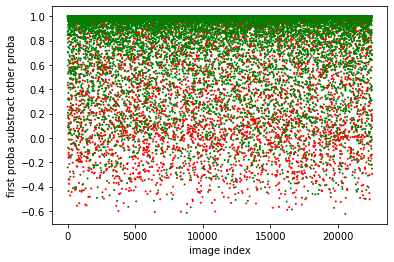

In [ ]:
plot_graph_first_not_all22(testy, model.predict(testX))